## Encoder and Decoder
- x -> Encoder -> z -> Decoder -> x_hat
- x와 x_hat의 차이가 가장 적도록 계산
- x -> z 압축 과정에서 정보가 최대한 보존되도록 손실 압축
- z -> x_hat 과정에서 Decoder는 x와 최대한 같아지도록 복원
- 이 과정에서 feature를 추출하는 방법을 자동 학습

### Encoder - 복원에 필요한 정보 중심으로 손실 압축
- x -> Encoder -> z(Bottleneck)
- 복원에 필요없는 정보들은 버릴 수 있음

### Bottleneck (z)
- x에 비해 작은 차원으로 구성
- 정보의 선택 및 압축이 발생, 차원에 따라 압축의 정도가 결정됨  

#### x에 대한 feature vector라고 할 수 있다.
- 압축이기에 입력보다 dense vector

### Decoder
- z를 바탕으로 x와 가장 유사한 x_hat 복원
- MSELoss를 통해 최적화 시행

### feature (z) 특징
- encoder를 통과한 feature들은 비슷한 샘플은 비슷한 공간에 위치
- input space -> encoder -> hidden(latent) space / Embedding
- hidden vector의 해석은 어려움, 단지 비슷한 특징끼리 묶임

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

In [7]:
from module.utils import load_mnist
from module.trainer import Trainer

In [8]:
from argparse import Namespace

config = {
    'train_ratio': .8,
    'batch_size': 256,
    'n_epochs': 50,
    'verbose': 1,
    'btl_size': 2
}

config = Namespace(**config)

print(config)

Namespace(train_ratio=0.8, batch_size=256, n_epochs=50, verbose=1, btl_size=2)


In [9]:
def show_image(x):
    if x.dim() == 1:
        x = x.view(int(x.size(0) ** .5), -1)
        
    plt.imshow(x, cmap='gray')
    plt.show()

In [15]:
train_x, train_y = load_mnist(flatten=True)
test_x, test_y = load_mnist(is_train=False, flatten=True)

train_cnt = int(train_x.size(0) * config.train_ratio)
valid_cnt = train_x.size(0) - train_cnt

indices = torch.randperm(train_x.size(0))

train_x, valid_x = torch.index_select(
    train_x,
    dim=0,
    index=indices,
).split([train_cnt, valid_cnt], dim=0)

train_y, valid_y = torch.index_select(
    train_y,
    dim=0,
    index=indices,
).split([train_cnt, valid_cnt], dim=0)

print("Train:", train_x.shape, train_y.shape)
print("Valid:", valid_x.shape, valid_y.shape)
print("Test:", test_x.shape, test_y.shape)

Train: torch.Size([48000, 784]) torch.Size([48000])
Valid: torch.Size([12000, 784]) torch.Size([12000])
Test: torch.Size([10000, 784]) torch.Size([10000])


In [16]:
from module.model import Autoencoder

In [38]:
# class Autoencoder(nn.Module):

#                       # bottleneck size
#     def __init__(self, btl_size=2):
#         self.btl_size = btl_size

#         super().__init__()

#         self.encoder = nn.Sequential(
#             nn.Linear(28 * 28, 500),
#             nn.ReLU(),
#             nn.BatchNorm1d(500),
#             nn.Linear(500, 200),
#             nn.ReLU(),
#             nn.BatchNorm1d(200),
#             nn.Linear(200, 100),
#             nn.ReLU(),
#             nn.BatchNorm1d(100),
#             nn.Linear(100, 50),
#             nn.ReLU(),
#             nn.BatchNorm1d(50),
#             nn.Linear(50, 20),
#             nn.ReLU(),
#             nn.BatchNorm1d(20),
#             nn.Linear(20, 10),
#             nn.ReLU(),
#             nn.BatchNorm1d(10),
#             nn.Linear(10, btl_size),
#         )

#         self.decoder = nn.Sequential(
#             nn.Linear(btl_size, 10),
#             nn.ReLU(),
#             nn.BatchNorm1d(10),
#             nn.Linear(10, 20),
#             nn.ReLU(),
#             nn.BatchNorm1d(20),
#             nn.Linear(20, 50),
#             nn.ReLU(),
#             nn.BatchNorm1d(50),
#             nn.Linear(50, 100),
#             nn.ReLU(),
#             nn.BatchNorm1d(100),
#             nn.Linear(100, 200),
#             nn.ReLU(),
#             nn.BatchNorm1d(200),
#             nn.Linear(200, 500),
#             nn.ReLU(),
#             nn.BatchNorm1d(500),
#             nn.Linear(500, 28 * 28),
#         )

#     def forward(self, x):
#         # |x| = (batch_size, 28*28)
#         # |z| = (batch_size, btl_size)
#         z = self.encoder(x)
#         y = self.decoder(z)
#         # |y| = |x|

#         return y

In [18]:
model = Autoencoder(btl_size=config.btl_size)
optimizer = optim.Adam(model.parameters())
crit = nn.MSELoss()

trainer = Trainer(model, optimizer, crit)

In [20]:
trainer.train((train_x, train_x), (valid_x, valid_x), config)

Epoch(1/50): train_loss=7.1020e-02  valid_loss=4.8493e-02  lowest_loss=4.8493e-02
Epoch(2/50): train_loss=4.6878e-02  valid_loss=4.4742e-02  lowest_loss=4.4742e-02
Epoch(3/50): train_loss=4.4411e-02  valid_loss=4.3425e-02  lowest_loss=4.3425e-02
Epoch(4/50): train_loss=4.3194e-02  valid_loss=4.2566e-02  lowest_loss=4.2566e-02
Epoch(5/50): train_loss=4.2381e-02  valid_loss=4.1252e-02  lowest_loss=4.1252e-02
Epoch(6/50): train_loss=4.1744e-02  valid_loss=4.0167e-02  lowest_loss=4.0167e-02
Epoch(7/50): train_loss=4.1058e-02  valid_loss=3.9800e-02  lowest_loss=3.9800e-02
Epoch(8/50): train_loss=4.1086e-02  valid_loss=4.0301e-02  lowest_loss=3.9800e-02
Epoch(9/50): train_loss=4.0657e-02  valid_loss=3.9801e-02  lowest_loss=3.9800e-02
Epoch(10/50): train_loss=4.0300e-02  valid_loss=3.9091e-02  lowest_loss=3.9091e-02
Epoch(11/50): train_loss=3.9809e-02  valid_loss=3.8970e-02  lowest_loss=3.8970e-02
Epoch(12/50): train_loss=3.9774e-02  valid_loss=3.9847e-02  lowest_loss=3.8970e-02
Epoch(13/50):

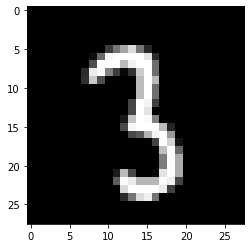

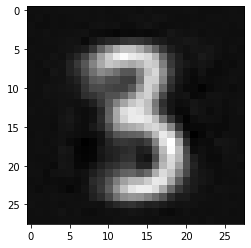

In [29]:
with torch.no_grad():
    import random
    
    index = int(random.random() * test_x.size(0))
    
    recon = model(test_x[index].view(1, -1)).squeeze()
    
    show_image(test_x[index])
    show_image(recon)

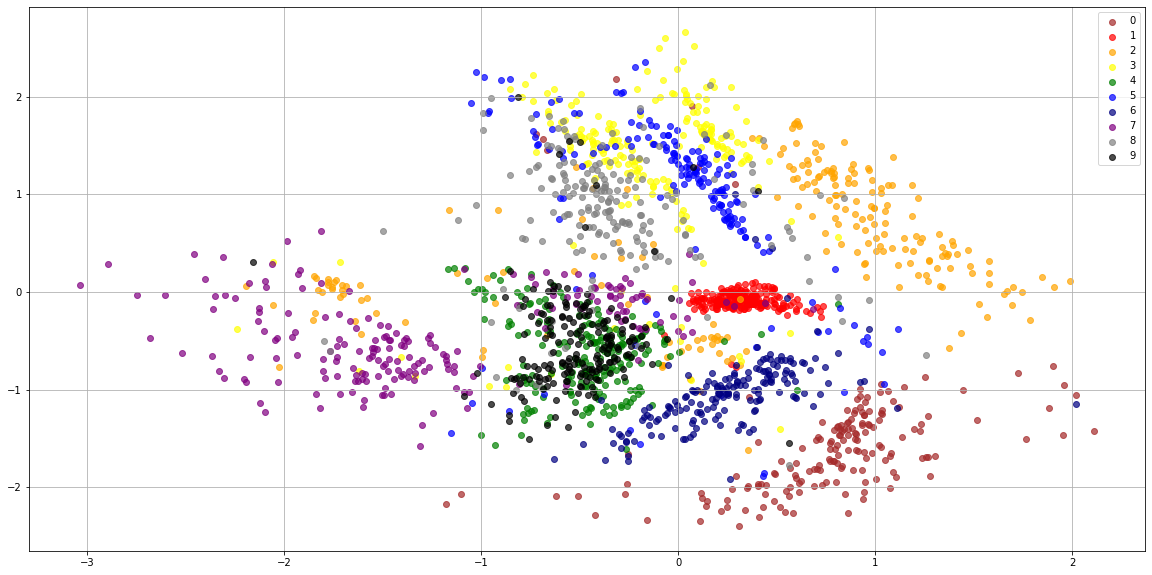

In [37]:
if config.btl_size == 2:
    color_map = [
        'brown', 'red', 'orange', 'yellow', 'green',
        'blue', 'navy', 'purple', 'gray', 'black',
    ]
    
    plt.figure(figsize=(20, 10))
    with torch.no_grad():
        latents = model.encoder(test_x[:2000])
        
        for i in range(10):
            target_latents = latents[test_y[:2000] == i]
#             target_y = test_y[:2000][test_y[:2000] == i]

            # btl_size가 2차원이기에 target_latents 2차원
            plt.scatter(target_latents[:, 0],
                        target_latents[:, 1],
                        marker='o',
                        color=color_map[i],
                        alpha=.7,
                        label=i)
        plt.legend()
        plt.grid(axis='both')
        plt.show()

### 위 그림에서 -2 ~ 2 범위에서 등간격으로 예측 결과값을 시각화.

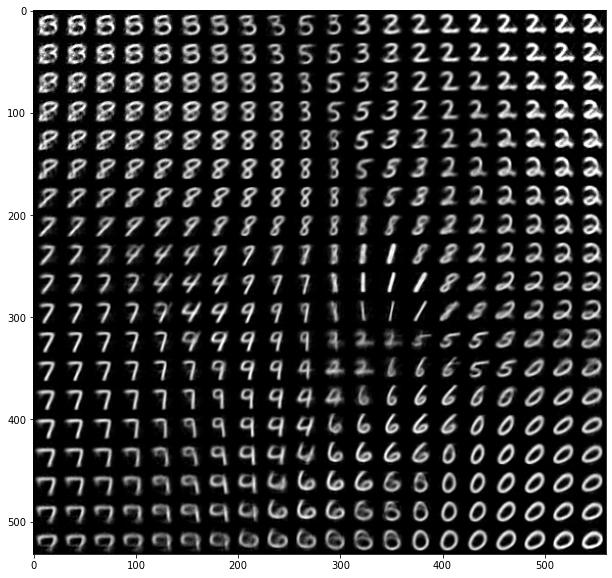

In [46]:
if config.btl_size == 2:
    min_range, max_range = -2., 2.
    n = 20
    step = (max_range - min_range) / float(n)
    
    with torch.no_grad():
        lines = []
        
        for v1 in np.arange(min_range, max_range, step):
            # v1 = 좌표 1
            # v2 = 좌표 2
            z = torch.stack([
                # v1 = [-2, -2, -2 ... -2]
                torch.FloatTensor([v1] * n),
                # v2 = [-2, -1.8, -1.6 ... 1.8]
                torch.FloatTensor([v2 for v2 in np.arange(min_range,
                                                          max_range,
                                                          step)]),
            ], dim=-1)
            # |v1| = (20,), |v2| = (20,)
            # |z| = (20, 2)
            
            # |decoder(z)| = (20, 28*28) => (20, 28, 28)
            # clamp = 범위 안에 라인을 쳐버림
            line = torch.clamp(model.decoder(z).view(n, 28, 28), 0, 1)
            
            # 위 그림과 동일하게 위치하도록 순서를 반대로 돌려줌.
            line = torch.cat([line[i] for i in range(n - 1, 0, -1)], dim=0)
            # |line| = (28 * 20, 28)
            lines += [line]
            
        # |lines| = (28 * 20, 28 * 20)
        lines = torch.cat(lines, dim=-1)
        
        plt.figure(figsize=(20, 10))
        show_image(lines)
        # 20 * 20 (n * n) 사이즈로 그려짐